<a href="https://colab.research.google.com/github/Marshmellowon/Mnist_VAE/blob/master/2_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoder**

Reference: Diederik P. Kingma and Max Welling, “Auto-Encoding Variational Bayes,” arXiv preprint arXiv:1312.6114, 2013.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from functools import reduce

# Mount drive
from google.colab import drive
drive.mount('/content/gdrive')

# Image directory
dir_image = '/content/gdrive/My Drive/Colab Notebooks/pic'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


###**Set training parameters**

In [ ]:
# Parameters
learning_rate = 1e-3
training_epochs = 50
batch_size = 32
display_step = 5

###**Load MNIST data**
Set train & test data

In [ ]:
# Load and prepare the MNIST dataset
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Split dataset
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32") / 255.0
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype("float32") / 255.0

# Batch datasets
train_data = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(60000)
    .batch(batch_size)
)
test_data = (
    tf.data.Dataset.from_tensor_slices(x_test)
    .shuffle(10000)
    .batch(batch_size)
)

In [ ]:
dim_x = np.shape(x_train)[1:]

###**Set model**


In [ ]:
class VAE(keras.Model):
  """a basic vae class for tensorflow
  Extends:
    tf.keras.Model
  """
  def __init__(self, **kwargs):
    super(VAE, self).__init__()
    self.__dict__.update(kwargs)

    self.dim_x_prod = reduce( (lambda x, y: x * y), self.dim_x)

    # Set network
    self.enc_nn = keras.Sequential(self.enc_desc)
    self.dec_nn = keras.Sequential(self.dec_desc)

  def encode(self, x):
    mu, log_sigma = tf.split(self.enc_nn(x), num_or_size_splits=2, axis=1)
    sigma = keras.backend.exp(log_sigma)
    return mu, log_sigma, sigma

  def decode(self, z):
    return self.dec_nn(z)

  def reparam(self, mu, sigma):
    """ Reparameterize. """
    eps = tf.random.normal(shape=mu.shape)
    return mu + eps * sigma

  def reconstruct(self, x):
    mu, _, _ = self.encode(x)
    return self.decode(mu)

  @tf.function
  def compute_loss(self, x):
    mu, log_sigma, sigma = self.encode(x)
    z = self.reparam(mu, sigma)
    x_recon = self.decode(z)
    
    # Compute KL-divergence
    _loss_latent = (-1/2) * (
        self.dim_z + tf.reduce_sum(log_sigma, axis=-1, keepdims=True) \
        - tf.reduce_sum(sigma, axis=-1, keepdims=True) \
        - tf.reduce_sum(mu**2, axis=-1, keepdims=True)
        )
    loss_latent = tf.reduce_mean(_loss_latent)

    # Compute reconstruction loss
    _diffsq_x = tf.math.square(x - x_recon)
    diffsq_x = tf.reshape(_diffsq_x, [-1, self.dim_x_prod])
    _loss_recon = tf.reduce_sum(diffsq_x, axis=-1, keepdims=True)
    loss_recon = tf.reduce_mean(_loss_recon)

    return loss_latent, loss_recon

  def compute_gradients(self, x):
    with tf.GradientTape() as tape:
        loss_latent, loss_recon = self.compute_loss(x)
        loss_sum = loss_latent + loss_recon
    cg = tape.gradient(loss_sum, self.enc_nn.trainable_variables + 
                       self.dec_nn.trainable_variables)
    return cg, loss_latent, loss_recon
  
  @tf.function
  def train(self, x):
    """ Trains model. """
    cg, loss_latent, loss_recon = self.compute_gradients(x)
    self.optimizer.apply_gradients(zip(cg, self.enc_nn.trainable_variables + 
                                       self.dec_nn.trainable_variables))
    return loss_latent, loss_recon

In [ ]:
dim_z = 2

enc_desc = [keras.layers.InputLayer(input_shape=dim_x, dtype=tf.float32),
            keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation="relu"),
            keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation="relu"),
            keras.layers.Flatten(),
            keras.layers.Dense(units=dim_z*2)]

dec_desc = [keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
            keras.layers.Reshape(target_shape=(7, 7, 64)),
            keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
            keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=(2, 2), padding="same", activation="relu"),
            keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=(1, 1), padding="same", activation="sigmoid")
            ]

# Set optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
vae = VAE(dim_x=dim_x, dim_z=dim_z, enc_desc=enc_desc, dec_desc=dec_desc, optimizer=optimizer)

### Train model

In [ ]:
# Test-data for plot
test_data_plot = next(iter(test_data))

import matplotlib.pyplot as plt

def plot_train(model, x, nex=6, zm=2, epoch=0):
  x_recon = model.reconstruct(x)
  x_sample = model.decode(tf.random.normal(shape=(batch_size, dim_z)))
  
  fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
  
  for axi, (dat, lab) in enumerate(zip([x, x_recon, x_sample],
                                       ["data", "data_recon", "data_sample"],)):
    for ex in range(nex):
      axs[axi, ex].matshow(
          dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
          )
      axs[axi, ex].axes.get_xaxis().set_ticks([])
      axs[axi, ex].axes.get_yaxis().set_ticks([])
      axs[axi, 0].set_ylabel(lab)

  plt.show()
  
  # Save fig
  figname2save = '{:s}/train_vae_z{:d}_{:d}.png'.format(dir_image,dim_z,epoch)
  fig.savefig(figname2save)

  plt.close()

In [ ]:
# Select metrics to measure the loss of the model
train_loss_latent = keras.metrics.Mean(name='train_loss_latent')
train_loss_recon = keras.metrics.Mean(name='train_loss_recon')
test_loss_latent = keras.metrics.Mean(name='train_loss_latent')
test_loss_recon = keras.metrics.Mean(name='train_loss_recon')

Epoch 1, Train-Loss: [1.6637,44.2409], Test-Loss: [2.2669,37.5048]


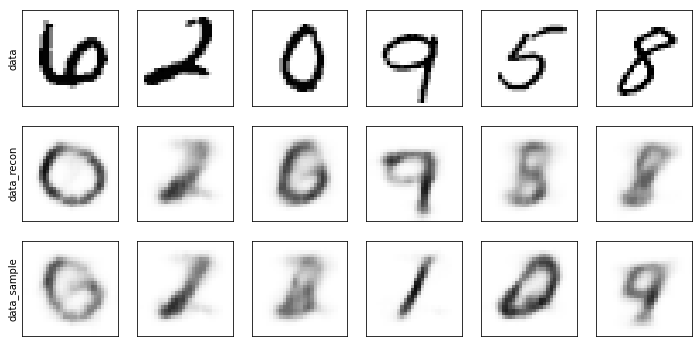

Epoch 2, Train-Loss: [2.3100,36.2369], Test-Loss: [2.3160,35.6329]
Epoch 3, Train-Loss: [2.4327,34.9433], Test-Loss: [2.4605,34.4771]
Epoch 4, Train-Loss: [2.5049,34.2653], Test-Loss: [2.6289,34.0332]
Epoch 5, Train-Loss: [2.5460,33.8350], Test-Loss: [2.6357,33.7348]
Epoch 6, Train-Loss: [2.5739,33.5624], Test-Loss: [2.5768,33.7972]


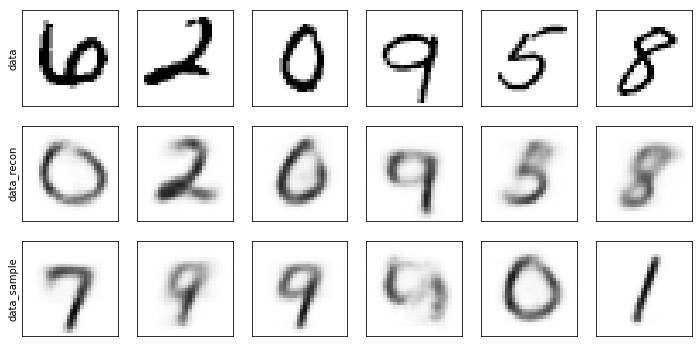

Epoch 7, Train-Loss: [2.5938,33.3399], Test-Loss: [2.4730,33.7496]
Epoch 8, Train-Loss: [2.6140,33.1777], Test-Loss: [2.7406,33.1349]
Epoch 9, Train-Loss: [2.6250,33.0345], Test-Loss: [2.6549,33.2113]
Epoch 10, Train-Loss: [2.6418,32.9101], Test-Loss: [2.6500,33.0068]
Epoch 11, Train-Loss: [2.6469,32.8381], Test-Loss: [2.6825,33.0338]


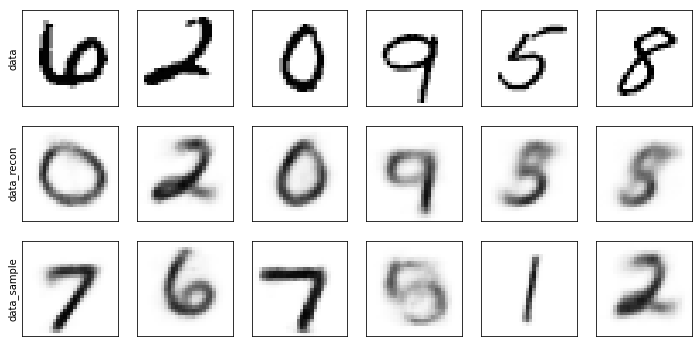

Epoch 12, Train-Loss: [2.6651,32.7189], Test-Loss: [2.5838,33.1023]
Epoch 13, Train-Loss: [2.6660,32.6309], Test-Loss: [2.7348,33.1657]
Epoch 14, Train-Loss: [2.6721,32.5509], Test-Loss: [2.6499,32.9596]
Epoch 15, Train-Loss: [2.6834,32.4877], Test-Loss: [2.6316,32.8841]
Epoch 16, Train-Loss: [2.6839,32.4371], Test-Loss: [2.7820,32.6599]


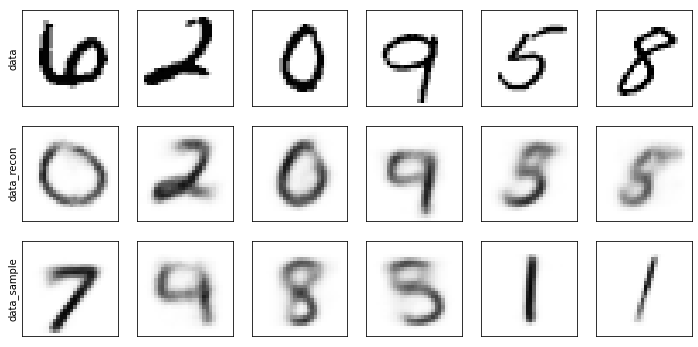

Epoch 17, Train-Loss: [2.6990,32.3694], Test-Loss: [2.7977,32.8230]
Epoch 18, Train-Loss: [2.7026,32.3076], Test-Loss: [2.6489,32.8622]
Epoch 19, Train-Loss: [2.7080,32.2775], Test-Loss: [2.7353,32.6646]
Epoch 20, Train-Loss: [2.7141,32.2088], Test-Loss: [2.7924,32.6256]
Epoch 21, Train-Loss: [2.7246,32.1670], Test-Loss: [2.7994,32.6376]


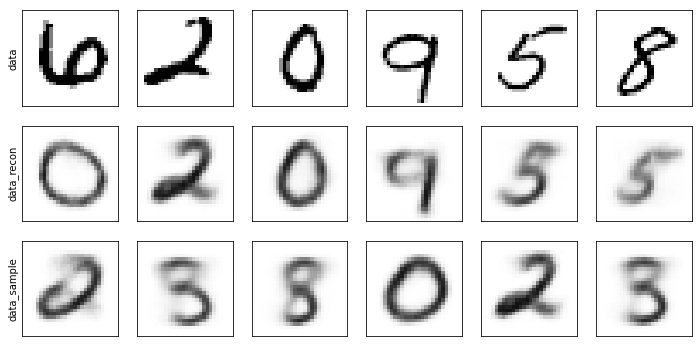

Epoch 22, Train-Loss: [2.7268,32.1351], Test-Loss: [2.7497,32.7076]
Epoch 23, Train-Loss: [2.7296,32.1007], Test-Loss: [2.7833,32.7446]
Epoch 24, Train-Loss: [2.7312,32.0442], Test-Loss: [2.6605,32.6744]
Epoch 25, Train-Loss: [2.7426,32.0225], Test-Loss: [2.6396,32.6676]
Epoch 26, Train-Loss: [2.7421,31.9921], Test-Loss: [2.6565,32.6612]


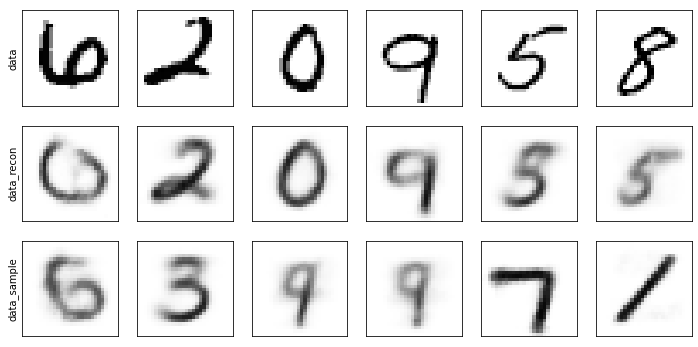

Epoch 27, Train-Loss: [2.7487,31.9593], Test-Loss: [2.7595,32.6465]
Epoch 28, Train-Loss: [2.7454,31.9292], Test-Loss: [2.7560,32.6317]
Epoch 29, Train-Loss: [2.7552,31.8953], Test-Loss: [2.7639,32.7335]
Epoch 30, Train-Loss: [2.7642,31.8713], Test-Loss: [2.7884,32.4820]
Epoch 31, Train-Loss: [2.7576,31.8526], Test-Loss: [2.6737,32.5515]


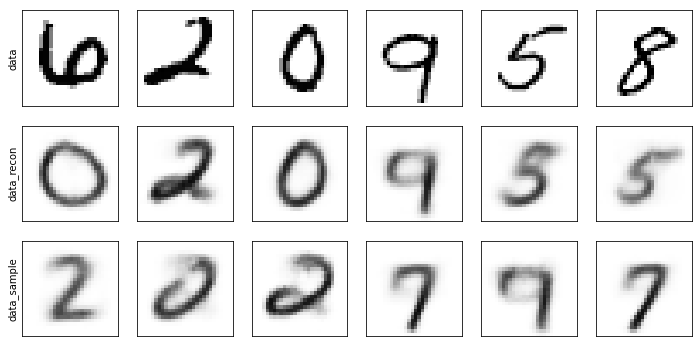

Epoch 32, Train-Loss: [2.7674,31.7996], Test-Loss: [2.8020,32.4973]
Epoch 33, Train-Loss: [2.7646,31.7882], Test-Loss: [2.7755,32.5528]
Epoch 34, Train-Loss: [2.7710,31.7663], Test-Loss: [2.6994,32.6940]
Epoch 35, Train-Loss: [2.7717,31.7545], Test-Loss: [2.7511,32.8714]
Epoch 36, Train-Loss: [2.7717,31.7154], Test-Loss: [2.7280,32.7968]


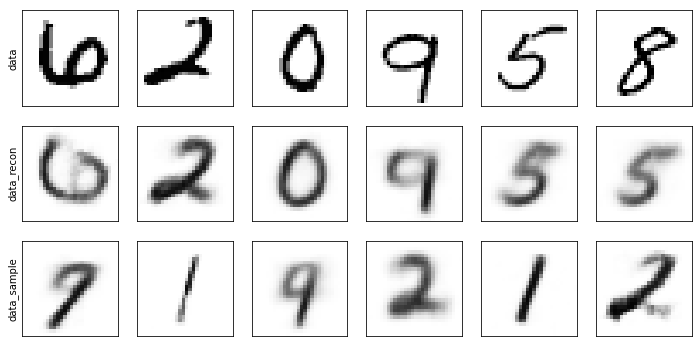

Epoch 37, Train-Loss: [2.7752,31.7071], Test-Loss: [2.7747,32.7719]
Epoch 38, Train-Loss: [2.7778,31.6747], Test-Loss: [2.7383,32.5893]
Epoch 39, Train-Loss: [2.7796,31.6656], Test-Loss: [2.7808,32.5452]
Epoch 40, Train-Loss: [2.7775,31.6445], Test-Loss: [2.8450,32.5084]
Epoch 41, Train-Loss: [2.7887,31.6101], Test-Loss: [2.8408,32.4541]


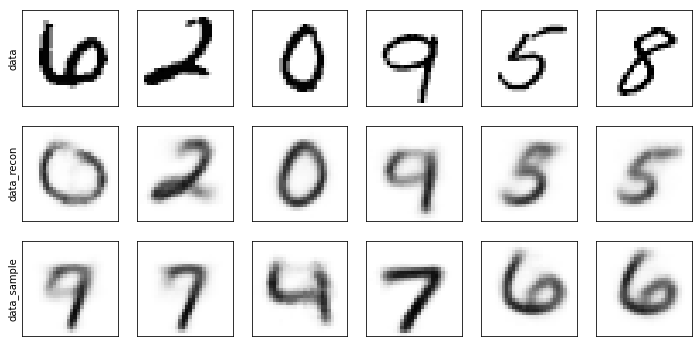

Epoch 42, Train-Loss: [2.7866,31.5940], Test-Loss: [2.8276,32.3912]
Epoch 43, Train-Loss: [2.7877,31.5940], Test-Loss: [2.7713,32.5129]
Epoch 44, Train-Loss: [2.7911,31.5517], Test-Loss: [2.7934,32.4424]
Epoch 45, Train-Loss: [2.7968,31.5609], Test-Loss: [2.7262,32.6021]
Epoch 46, Train-Loss: [2.7995,31.5448], Test-Loss: [2.7557,32.5530]


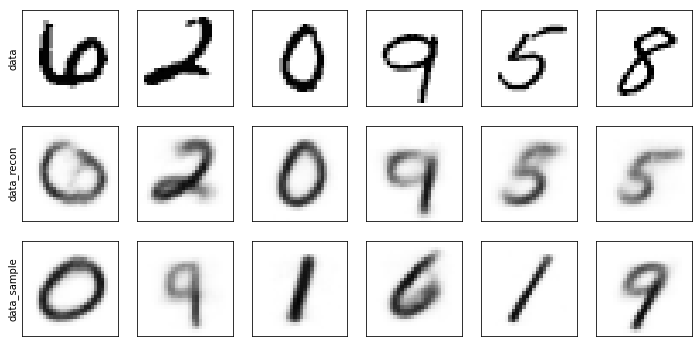

Epoch 47, Train-Loss: [2.7924,31.5309], Test-Loss: [2.8995,32.4997]
Epoch 48, Train-Loss: [2.7996,31.5080], Test-Loss: [2.8111,32.4487]
Epoch 49, Train-Loss: [2.8077,31.5041], Test-Loss: [2.8094,32.5409]
Epoch 50, Train-Loss: [2.8017,31.4635], Test-Loss: [2.8268,32.4105]


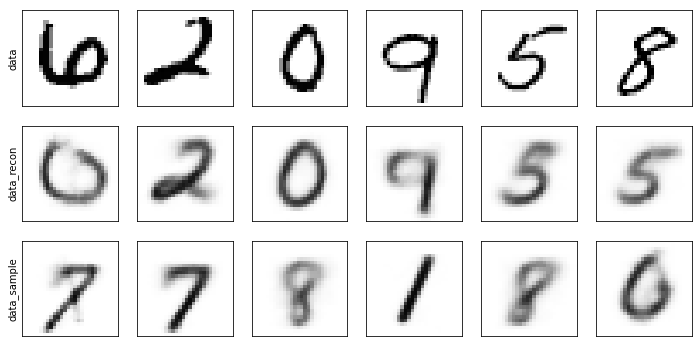

In [ ]:
# Run training for the given number of steps.
for epoch in range(training_epochs):
  for x_batch in train_data:
    loss_latent, loss_recon = vae.train(x_batch)
    train_loss_latent(loss_latent)
    train_loss_recon(loss_recon)

  for x_batch_t in test_data:
    loss_latent_t, loss_recon_t = vae.compute_loss(x_batch_t)
    test_loss_latent(loss_latent_t)
    test_loss_recon(loss_recon_t)

  template = 'Epoch {:d}, Train-Loss: [{:2.4f},{:2.4f}], Test-Loss: [{:2.4f},{:2.4f}]'
  print(template.format(epoch+1, train_loss_latent.result(),
                        train_loss_recon.result(), test_loss_latent.result(),
                        test_loss_recon.result()))

  if epoch % display_step == 0 or epoch == (training_epochs-1):  
    plot_train(vae, test_data_plot, epoch=epoch+1)

  # Reset the metrics for the next epoch
  train_loss_latent.reset_states()
  train_loss_recon.reset_states()
  test_loss_latent.reset_states()
  test_loss_recon.reset_states()

### Plot grid in 2D latent space

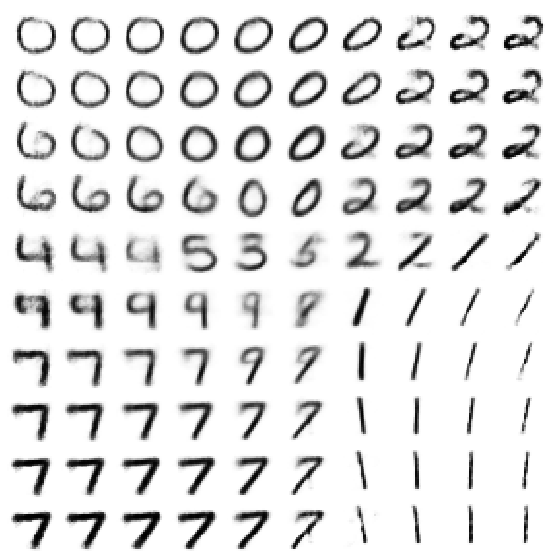

In [ ]:
# Sample from grid
nx = ny =10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = vae.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)
# Fill canvas
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')

# Save fig
figname2save = '{:s}/vae_z{:d}_grid.png'.format(dir_image,dim_z)
fig.savefig(figname2save)